In [1]:
import numpy as np
import torch
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
from pathlib import Path
import h5py

# 1) block 'blood-oxygen' 
cur = Path.cwd()
bo_root = next(p for p in [cur, *cur.parents] if p.name == "blood-oxygen")

# 2) into spo2-phonecam (subsystem of author)
spo2_root = bo_root / "spo2-phonecam"

# 3) (form the pathway of data.h5)
H5 = (spo2_root / "external/oximetry-phone-cam-data/data/preprocessed/all_uw_data.h5").resolve()
print("Using:", H5)
assert H5.exists(), f"not exist：{H5}"

# 4) read
with h5py.File(H5, "r") as f:
    print("Keys:", list(f.keys()))
    data = f["dataset"][:]
    gt   = f["groundtruth"][:]
print(data.shape, gt.shape)


Using: /Users/katyhuang/Desktop/blood-oxygen/spo2-phonecam/external/oximetry-phone-cam-data/data/preprocessed/all_uw_data.h5
Keys: ['dataset', 'groundtruth']
(6, 6, 33660) (6, 5, 1122)


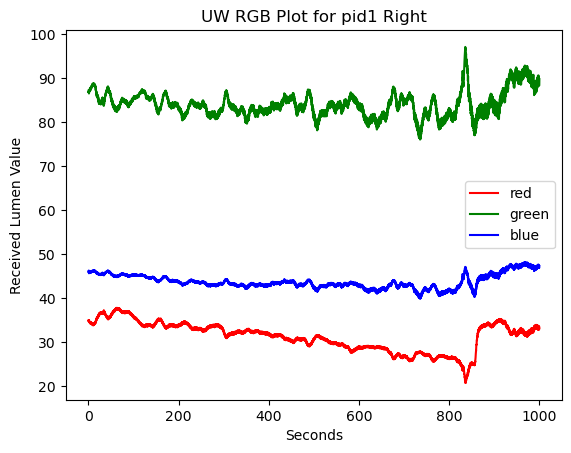

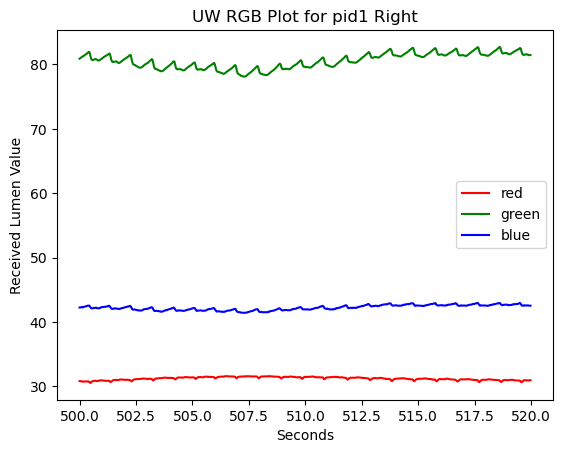

In [3]:
# Plot the red, green, and blue chanel in the time range. Choose either left or right hand.
def plot_RGB(data, pid=0, left=True, sec_from=0, sec_to=1000):
    title = "pid" + str(pid+1)
    X = np.arange(sec_from, sec_to, 1/30)
    if left:
        plt.plot(X, data[pid, 0, sec_from*30:sec_to*30], label="red", color="red")
        plt.plot(X, data[pid, 1, sec_from*30:sec_to*30], label="green", color="green")
        plt.plot(X, data[pid, 2, sec_from*30:sec_to*30], label="blue", color="blue")
        title += " Left"
    else:
        plt.plot(X, data[pid, 3, sec_from*30:sec_to*30], label="red", color="red")
        plt.plot(X, data[pid, 4, sec_from*30:sec_to*30], label="green", color="green")
        plt.plot(X, data[pid, 5, sec_from*30:sec_to*30], label="blue", color="blue")
        title += " Right"
    plt.title("UW RGB Plot for " + title)
    plt.legend()
    plt.xlabel("Seconds")
#     plt.ylim(0, 250)
    plt.ylabel("Received Lumen Value")
    plt.show()
    
plot_RGB(data, pid=0, left=False, sec_from=0, sec_to=1000)
plot_RGB(data, pid=0, left=False, sec_from=500, sec_to=520)

In [4]:
# Make a list of data points for visualizing or training
def make_temp_data(data_uw, groundtruth_uw, data_idx=[], gt_ind = 3):
    # Select 0th sample, right hand
    res_data_list = []
    res_gt_list = []
    for pid, row in enumerate(data_idx):
        if row[0] == 1:
            res_data_list.append(data_uw[pid][:3,:])
            res_gt_list.append(groundtruth_uw[pid][gt_ind,:])
        if row[1] == 1:
            res_data_list.append(data_uw[pid][3:,:]) 
            res_gt_list.append(groundtruth_uw[pid][gt_ind, :])

    results_data_list = []
    results_gt_list = []
    fps_list = []
    for i in range(len(res_gt_list)):
        # find zeros
        zeros_data = np.where(res_data_list[i][0] == 0)[0]
        zeros_gt = np.where(res_gt_list[i] == 0)[0]

        if len(zeros_data) > 0:
            result_data_i = res_data_list[i][:, :int(zeros_data[0])]
        else:
            result_data_i = res_data_list[i]
        if len(zeros_gt) > 0:
            result_gt_i = res_gt_list[i][:int(zeros_gt[0])]
        else:
            result_gt_i = res_gt_list[i]

        # Calculate shorter and clip
        fps = 30
        clip_len = min(result_gt_i.shape[0], result_data_i.shape[1] // fps)
        result_data_i = result_data_i[:, :clip_len*fps]
        result_gt_i = result_gt_i[:clip_len]

        results_gt_list.append(result_gt_i)
        results_data_list.append(result_data_i)
        fps_list.append(fps)

    return {"data": results_data_list, "gt": results_gt_list, "fps": fps_list}

In [5]:
try:
    groundtruth
except NameError:
    groundtruth = gt

UW: mean=87.220673, std=9.325543


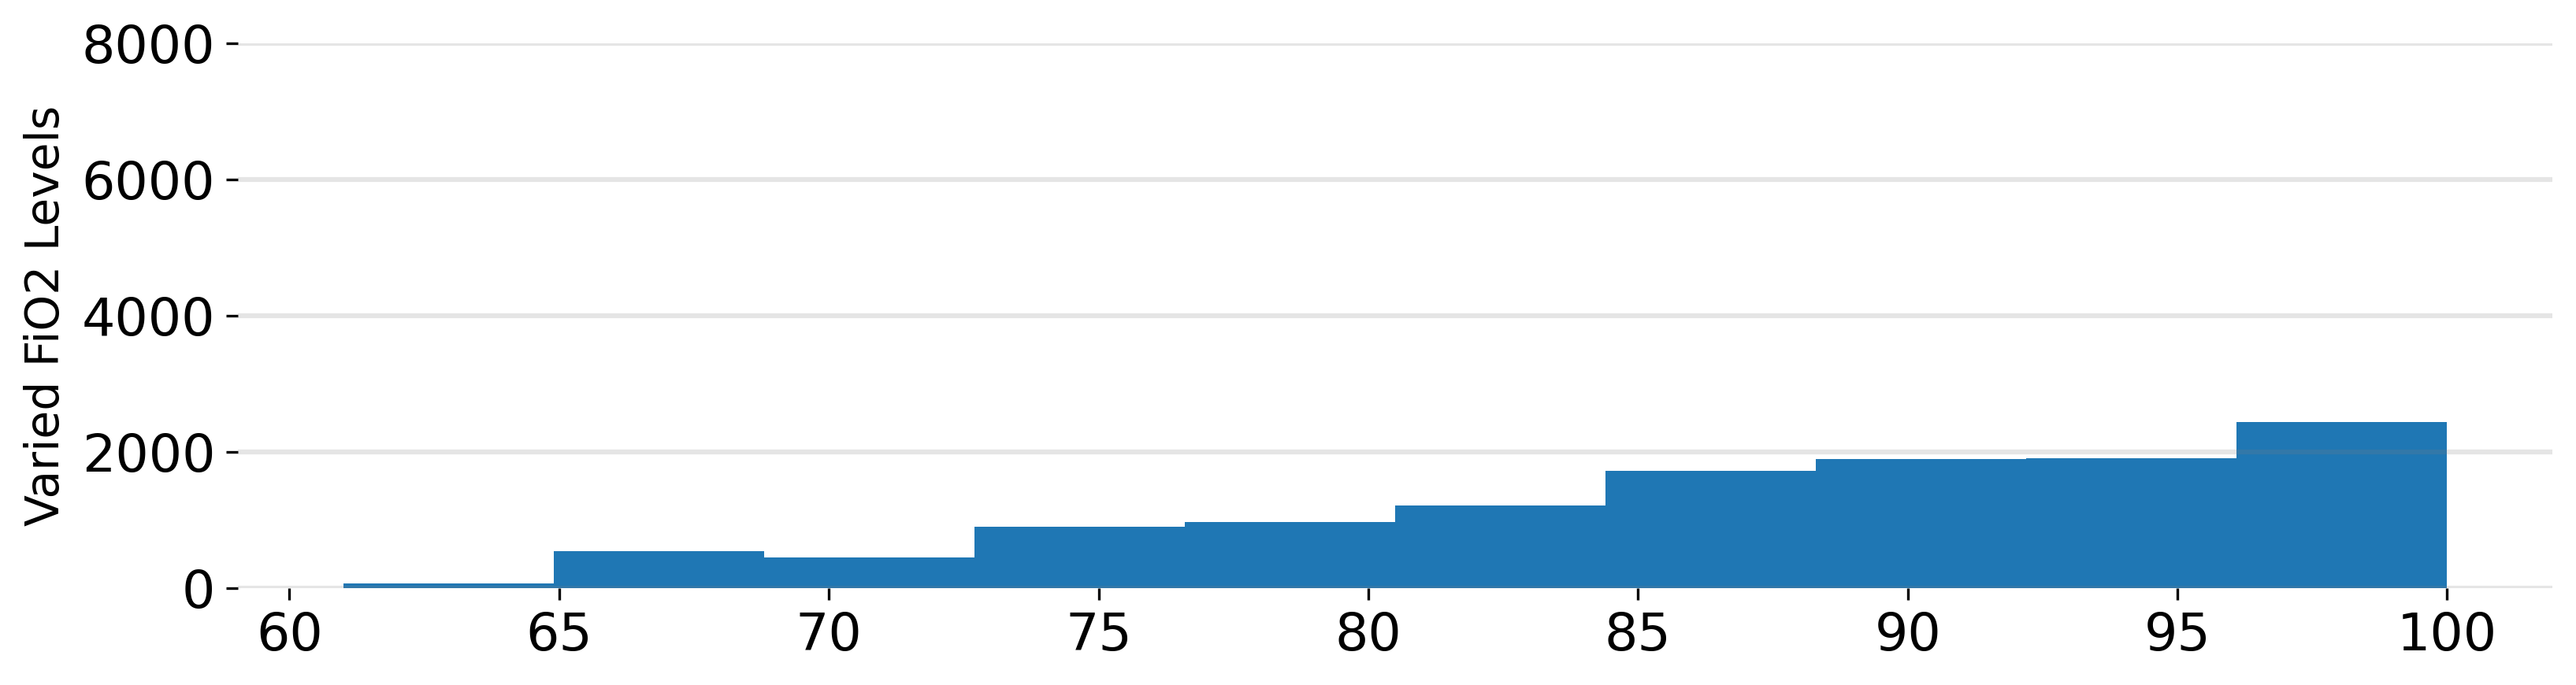

In [6]:
# Plot a historgram of the data distribution
def hist_UW():
    all_data_idx = np.ones((6,2))
    all_seq = make_temp_data(data, groundtruth, gt_ind=3, data_idx=all_data_idx)
    gtdatapoints = []
    for seq in all_seq["gt"]:
        gtdatapoints.extend(seq)
    gtdatapoints = np.array(gtdatapoints)
    print('UW: mean=%f, std=%f' % \
          (np.mean(gtdatapoints),np.std(gtdatapoints)))
    plt.figure(figsize=(11,3),dpi=300)
    plt.hist(gtdatapoints,bins=10, )
    ax = plt.gca()

    ax.set_ylim(top=8000)

    locs = ax.yaxis.get_ticklocs()
    labs = ax.yaxis.get_ticklabels()
    # print([lab.get_text() for lab in ax.yaxis.get_ticklabels()])
    new_locs = []
    new_labs = []
    for i, (loc, lab) in enumerate(list(zip(locs, labs))):
        if (i) % 2 == 0:
            # if i == 0:
            #     continue
            new_locs.append(loc)
            new_labs.append(lab)
            plt.axhline(y=loc, color="grey", alpha=0.2)

    ax.set_yticks(new_locs)
    ax.set_yticklabels(["0", "2000", "4000", "6000", "8000"], fontsize=16)

    # ax.set_xticks(ax.get_xticks(), fontsize=16)
    plt.setp(ax.get_xticklabels(), fontsize=16)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

    ax.set_ylabel("Varied FiO2 Levels", fontsize=14)
    plt.tight_layout()

hist_UW()

In [7]:

#location of the author folder 
PATH = '../spo2-phonecam/external/oximetry-phone-cam-data/data/preprocessed'  # 字符串

def load_metadata(metapath):
    import pandas as pd
    return pd.read_csv(metapath)

# View metadata descriptions
meta_df = load_metadata(metapath=f'{PATH}/../gt/metadata.csv')
print(meta_df.shape)


(44, 3)


In [8]:
# View metadata descriptions
def load_metadata(metapath):
    meta_df = pd.read_csv(metapath)
#     print()
    return meta_df

load_metadata(metapath=f'{PATH}//..//gt/metadata.csv')

,Label,Description,Unit
0,SpO2 1,SpO2 reading from PPG of pulse ox 1 (3900P TT+...,Percentage
1,SpO2 2,SpO2 reading from PPG of pulse ox 2 (Nellcor N...,Percentage
2,SpO2 3,Unfilled signal from pulse ox 3 (Safety Oxim 3...,Unknown
3,SpO2 4,SpO2 reading from PPG of pulse ox 4 (Nellcor N...,Percentage
4,SpO2 5,SpO2 reading from PPG of pulse ox 5 (Masimo Ra...,Percentage
5,Pulse 1,Heart rate from PPG of pulse ox 1 (3900P TT+ 9...,bpm
6,Pulse 2,Heart rate from PPG of pulse ox 2 (Nellcor N-6...,bpm
7,Pulse 3,Unfilled signal from pulse ox 3 (Safety Oxim 3...,Unknown
8,Pulse 4,Heart rate from PPG of pulse ox 4 (Nellcor N-6...,bpm
9,Pulse 5,Heart rate from PPG of pulse ox 5 (Masimo Radi...,bpm


In [318]:
# === Fig.1: Ground-truth parsing, hand selection, DCNorm windowing ===
from __future__ import annotations
from typing import Sequence, Tuple, Optional, List
import numpy as np

def pick_time_spo2_rows(gt_s, fallback_hz: float = 30.0) -> Tuple[np.ndarray, np.ndarray]:
    """
    Minimal & robust: return (t, y) for one subject.
    Accepts:
      - dict-like with keys 't'/'time' and 'y'/'spo2'/'SpO2'
      - array with shape [...,2] as [t,y]; or 1D [y] (then t is built by fallback_hz)
    Cleans NaN/Inf and stable-sorts by time if needed.
    """
    if isinstance(gt_s, dict):
        t = gt_s.get('t', gt_s.get('time', None))
        y = gt_s.get('y', gt_s.get('spo2', gt_s.get('SpO2', None)))
        if t is None or y is None:
            raise ValueError("groundtruth dict must contain 't'/'time' and 'y'/'spo2'/'SpO2'")
        t = np.asarray(t, float).ravel()
        y = np.asarray(y, float).ravel()
    else:
        a = np.asarray(gt_s, float)
        if a.ndim == 2 and a.shape[1] >= 2:
            t = a[:, 0].astype(float).ravel()
            y = a[:, 1].astype(float).ravel()
        elif a.ndim == 1:
            y = a.astype(float).ravel()
            t = np.arange(len(y), dtype=float) / float(fallback_hz)
        else:
            raise ValueError(f"Cannot parse groundtruth shape: {a.shape}")

    m = np.isfinite(t) & np.isfinite(y)
    t, y = t[m], y[m]
    if t.size >= 2 and not np.all(np.diff(t) > 0):
        idx = np.argsort(t, kind="stable")
        t, y = t[idx], y[idx]
    return t, y

def _acdc_score(chunk: np.ndarray, eps: float = 1e-6) -> float:
    """mean(std/|mean|) across channels — a simple AC/DC quality proxy."""
    dc = np.mean(chunk, axis=0)
    ac = np.std(chunk, axis=0)
    return float(np.mean(ac / (np.abs(dc) + eps)))

def _dc_norm(chunk: np.ndarray) -> np.ndarray:
    """(chunk - mean)/mean per-channel DC normalization."""
    dc = np.mean(chunk, axis=0)
    dc = np.where(np.abs(dc) < 1e-6, 1e-6, dc)
    return (chunk - dc) / dc

def choose_hand_per_subject(data: Sequence[np.ndarray]) -> List[str]:
    """
    If >=6 channels, assume [0:3]=Left, [3:6]=Right; choose hand with higher AC/DC.
    If <6 channels, default to 'L' and use all channels.
    """
    out = []
    for sig in data:
        sig = np.asarray(sig, float)
        C = sig.shape[1] if sig.ndim == 2 else 1
        if C >= 6:
            L, R = sig[:, :3], sig[:, 3:6]
            out.append('L' if _acdc_score(L) >= _acdc_score(R) else 'R')
        else:
            out.append('L')
    return out

def make_windows_5s_dcnorm(
    data: Sequence[np.ndarray],
    groundtruth: Sequence,
    hand_sel: Optional[Sequence[str]] = None,
    lag_sec: float = 40.0,
    acdc_thr: float = 0.02,
    fallback_hz: float = 30.0,
    target_fps: float = 30.0,
    y_valid_range: Tuple[float, float] = (60.0, 100.0),  # ★ 放宽到 60–100
    verbose: bool = False,
    step_ratio: float = 0.10,   # ★ 90% overlap
    win_sec: float = 5.0,       # ★ 5 second windows
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Build windows with DCNorm and AC/DC gating.
    Label = GT(center_time + lag_sec) via linear interpolation.
    Returns:
        Xb: (N, C, W), yb: (N,), ob: (N,) subject index
    """
    Xs, Ys, Obs = [], [], []
    W = int(round(float(win_sec) * float(target_fps)))
    step = max(1, int(round(step_ratio * W)))

    dropped_bad = 0
    total_tried = 0

    for s in range(len(data)):
        sig = np.asarray(data[s], dtype=np.float32)
        if sig.ndim == 1:
            sig = sig[:, None]
        if sig.shape[0] < sig.shape[1]:
            sig = sig.T  # 保证 T×C

        # 选手
        C = sig.shape[1]
        use = slice(0, C)
        if hand_sel is not None and C >= 6:
            use = slice(0, 3) if hand_sel[s] == 'L' else slice(3, 6)
        sig = sig[:, use]

        gt_t, gt_y = pick_time_spo2_rows(groundtruth[s], fallback_hz=fallback_hz)
        if gt_t.size < 2:
            continue

        T = sig.shape[0]
        if T < W:
            continue

        # only under GT range：center+lag <= gt_t[-1]
        max_center_sec = float(gt_t[-1]) - float(lag_sec)
        if max_center_sec <= 0:
            continue
        max_start_idx = int(np.floor(max_center_sec * target_fps - 0.5 * W))
        if max_start_idx < 0:
            continue

        end_idx = min(T - W, max_start_idx)
        if end_idx < 0:
            continue

        for start in range(0, end_idx + 1, step):
            chunk = sig[start:start + W, :]
            total_tried += 1

            # quality
            if _acdc_score(chunk) < acdc_thr:
                dropped_bad += 1
                continue

            # DCNorm
            x_win = _dc_norm(chunk).astype(np.float32, copy=False)

            # label
            center_sec = (start + 0.5 * W) / float(target_fps)
            y_time = center_sec + float(lag_sec)
            y_val = float(np.interp(y_time, gt_t, gt_y, left=np.nan, right=np.nan))
            if not np.isfinite(y_val):
                continue
            if not (y_valid_range[0] <= y_val <= y_valid_range[1]):
                continue

            Xs.append(x_win.T)    # (C, W)
            Ys.append(y_val)
            Obs.append(s)

    if verbose:
        print(f"[build] kept={len(Xs)}, dropped_bad={dropped_bad} / tried={total_tried}")

    if not Xs:
        raise RuntimeError("No valid windows. Try lowering acdc_thr to 0.015.")

    Xb = np.stack(Xs).astype(np.float32)
    yb = np.asarray(Ys, dtype=np.float32).ravel()
    ob = np.asarray(Obs, dtype=np.int32).ravel()
    return Xb, yb, ob


In [325]:
import numpy as np
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LinearRegression

class Shallow1DCNN(nn.Module):
    def __init__(self, in_ch: int, k: int = 7, p_drop: float = 0.2):
        super().__init__()
        self.feat = nn.Sequential(
            nn.Conv1d(in_ch, 64, kernel_size=k, padding=k//2),
            nn.BatchNorm1d(64), nn.ReLU(inplace=True),
            nn.Conv1d(64,128, kernel_size=k, padding=k//2),
            nn.BatchNorm1d(128), nn.ReLU(inplace=True),
            nn.Conv1d(128,64, kernel_size=k, padding=k//2),
            nn.BatchNorm1d(64), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool1d(1),
            nn.Dropout(p_drop),
        )
        self.head = nn.Sequential(
            nn.Linear(64,64), nn.ReLU(inplace=True),
            nn.Dropout(p_drop),
            nn.Linear(64,1),
        )
    def forward(self, x):
        h = self.feat(x).squeeze(-1)
        return self.head(h).squeeze(-1)

@torch.no_grad()
def _predict(model: nn.Module, dl: DataLoader, device: str) -> np.ndarray:
    out = []
    for b in dl:
        xb = b[0] if isinstance(b,(list,tuple)) else b
        xb = xb.to(device)
        out.append(model(xb).detach().cpu().numpy())
    return np.concatenate(out, axis=0)

from torch.utils.data import WeightedRandomSampler

def _build_loader(X: np.ndarray, y: np.ndarray | None, bs: int,
                  shuffle: bool, sample_weights: np.ndarray | None = None) -> DataLoader:
    ds = TensorDataset(torch.from_numpy(X).float()) if y is None else \
         TensorDataset(torch.from_numpy(X).float(), torch.from_numpy(y).float())
    if sample_weights is not None:
        sw = torch.as_tensor(sample_weights, dtype=torch.float32)
        sampler = WeightedRandomSampler(weights=sw, num_samples=len(sw), replacement=True)
        return DataLoader(ds, batch_size=bs, sampler=sampler)
    return DataLoader(ds, batch_size=bs, shuffle=shuffle)


def train_and_eval_once(
    X_tr, y_tr, X_va, y_va, X_te, y_te,
    low_weight: float = 16.0, epochs: int = 180,
    base_lr: float = 3e-4, wd: float = 1e-4, bs: int = 96, patience: int = 12,
    device: str = 'cpu',
    ob_tr: np.ndarray | None = None,            # equalizing the sampling of the subjects
    y_range: tuple[float, float] | None = None  # evaluating/trimming the range
):
    n_tr, n_va, n_te = len(X_tr), len(X_va), len(X_te)
    if (n_tr == 0) or (n_va == 0) or (n_te == 0):
        return {
            "mae_va": float("inf"),
            "mae_te": float("inf"),
            "y_te": y_te,
            "y_te_hat": np.full_like(y_te, np.nan)
        }

    model = Shallow1DCNN(in_ch=X_tr.shape[1]).to(device)
    opt   = torch.optim.AdamW(model.parameters(), lr=base_lr, weight_decay=wd)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=max(10, epochs))

    def mae(a, b): return float(np.mean(np.abs(np.asarray(a) - np.asarray(b))))

    # -------- Subject equalization sampling: The total sampling weights of each subject should be as close as possible --------
    sample_weights = None
    if ob_tr is not None:
        uniq, cnt = np.unique(ob_tr, return_counts=True)
        per_subj = {u: 1.0/float(c) for u, c in zip(uniq, cnt)}
        sample_weights = np.asarray([per_subj[o] for o in ob_tr], dtype=np.float32)

    tr_dl = _build_loader(X_tr, y_tr, bs, shuffle=True,  sample_weights=sample_weights)
    va_dl = _build_loader(X_va, y_va, bs, shuffle=False)
    te_dl = _build_loader(X_te, None,  bs, shuffle=False)

    # -------- Adaptive hypoxia threshold (20% percentile of the training set）--------
    thr = float(np.percentile(y_tr, 20))
    lw  = torch.tensor(low_weight, dtype=torch.float32, device=device)

    best = {"mae_va": float("inf"), "state": None, "epoch": -1}
    bad = 0

    for ep in range(1, epochs + 1):
        model.train()
        for xb, yb in tr_dl:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad(set_to_none=True)
            pred = model(xb)
            thr_t = torch.as_tensor(thr, dtype=yb.dtype, device=yb.device)
            w = torch.where(yb <= thr_t, lw, 1.0)             # ★ Use adaptive thr
            loss = (torch.abs(pred - yb) * w).mean()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
        sched.step()

        model.eval()
        yv_hat = _predict(model, va_dl, device)
        m_va = mae(yv_hat, y_va)
        if m_va + 1e-6 < best["mae_va"]:
            best.update({
                "mae_va": m_va,
                "state": {k: v.detach().cpu().clone() for k, v in model.state_dict().items()},
                "epoch": ep,
            })
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                break

    if best["state"] is None:
        return {
            "mae_va": float("inf"),
            "mae_te": float("inf"),
            "y_te": y_te,
            "y_te_hat": np.full_like(y_te, np.nan)
        }

    model.load_state_dict(best["state"])
    model.eval()

    # -------- Monotonic calibration (prediction based on training set) --------
    tr_pred = _predict(model, _build_loader(X_tr, None, bs, shuffle=False), device)
    try:
        iso = IsotonicRegression(out_of_bounds="clip").fit(tr_pred, y_tr)
        calibrator = ("iso", iso)
    except Exception:
        lr = LinearRegression().fit(tr_pred.reshape(-1, 1), y_tr.reshape(-1, 1))
        calibrator = ("lin", lr)

    # Take the verification/test prediction uniformly and then perform calibration

    yv_hat = _predict(model, va_dl, device)
    yt_hat = _predict(model, te_dl, device)
    if calibrator[0] == "iso":
        yv_hat = calibrator[1].transform(yv_hat)
        yt_hat = calibrator[1].transform(yt_hat)
    else:
        yv_hat = calibrator[1].predict(yv_hat.reshape(-1, 1)).ravel()
        yt_hat = calibrator[1].predict(yt_hat.reshape(-1, 1)).ravel()

    # -------- Crop according to the evaluation criteria (default consistent with window build)--------
    lo, hi = (y_range if y_range is not None else (60.0, 100.0))
    yv_hat = np.clip(yv_hat, lo, hi)
    yt_hat = np.clip(yt_hat, lo, hi)

    return {
        "mae_va": mae(yv_hat, y_va),
        "mae_te": mae(yt_hat, y_te),
        "y_te": y_te,
        "y_te_hat": yt_hat,
    }


In [320]:
import inspect, torch.nn as nn
print(inspect.signature(train_and_eval_once))
m = Shallow1DCNN(in_ch=6)
print(m.feat[0].out_channels, isinstance(m.feat[1], nn.BatchNorm1d))



(X_tr, y_tr, X_va, y_va, X_te, y_te, low_weight: 'float' = 16.0, epochs: 'int' = 180, base_lr: 'float' = 0.0003, wd: 'float' = 0.0001, bs: 'int' = 96, patience: 'int' = 12, device: 'str' = 'cpu', ob_tr: 'np.ndarray | None' = None, y_range: 'tuple[float, float] | None' = None)
64 True


In [326]:
def run_loso_with_lag_sweep(
    data, groundtruth, hands=None,
    acdc_thr: float = 0.010,
    candidate_lags=(25, 30),
    low_weight: float = 16.0,
    epochs: int = 180,
    base_lr: float = 3e-4,
    wd: float = 1e-4,
    bs: int = 96,
    patience: int = 12,
    device: str = 'cpu',
    val_frac: float = 0.2,
    seed: int = 42,
    y_valid_range=(60.0, 100.0),
    min_train_windows: int = 15,
    min_test_windows: int = 3,
    step_ratio: float = 0.10,   # 90% 重叠
    win_sec: float = 5.0,
    quiet: bool = True,
):
    rng = np.random.default_rng(seed)
    out = []
    S = len(data)

    def lags_for_subject(te):
        gt_t, _ = pick_time_spo2_rows(groundtruth[te], fallback_hz=30.0)
        safe_lag = float(gt_t[-1]) - 0.5 * float(win_sec) if gt_t.size > 0 else 0.0
        base = [float(l) for l in candidate_lags]
        l = [x for x in base if x <= safe_lag + 1e-6]
        if not l:
            l = [max(5.0, min(10.0, safe_lag))]
        return sorted({float(f"{x:.2f}") for x in l})

    _cache = {}
    def get_windows(lag: float):
        key = float(lag)
        if key not in _cache:
            _cache[key] = make_windows_5s_dcnorm(
                data, groundtruth, hands,
                lag_sec=key, acdc_thr=acdc_thr,
                fallback_hz=30.0, target_fps=30.0,
                y_valid_range=y_valid_range, verbose=False,
                step_ratio=step_ratio, win_sec=win_sec,   # ★ into
            )
        return _cache[key]

    for te in range(S):
        if not quiet:
            print(f"[te={te}] sweep lags ...", flush=True)
        best = None

        for lag in lags_for_subject(te):
            try:
                Xb, yb, ob = get_windows(lag)
            except RuntimeError as e:
                if not quiet:
                    print(f"    lag={int(round(lag))} s -> {e} (skip)", flush=True)
                continue

            m_te = (ob == te)
            m_tr = ~m_te
            if m_tr.sum() < min_train_windows or m_te.sum() < min_test_windows:
                if not quiet:
                    print(f"    lag={int(round(lag))} s -> too few windows (tr={int(m_tr.sum())}, te={int(m_te.sum())})", flush=True)
                continue

            idx_tr = np.where(m_tr)[0]
            rng.shuffle(idx_tr)
            k = max(1, int(round(val_frac * idx_tr.size)))
            va_idx = idx_tr[:k]
            tr_idx = idx_tr[k:] if k < idx_tr.size else idx_tr

            res = train_and_eval_once(
                Xb[tr_idx], yb[tr_idx], Xb[va_idx], yb[va_idx],
                Xb[m_te],  yb[m_te],
                low_weight=low_weight, epochs=epochs,
                base_lr=base_lr, wd=wd, bs=bs, patience=patience, device=device,
                ob_tr=ob[tr_idx],                # ★ 
                y_range=y_valid_range            # ★ 
            )

            if not quiet:
                print(f"    lag={int(round(lag))} s -> val MAE={res['mae_va']:.3f}", flush=True)

            if (best is None) or (res['mae_va'] < best['mae_va']):
                best = {"lag": float(lag), **res}

        if best is None:
            out.append({"te": te, "lag": None, "mae_te": float('nan'), "n_te": 0})
            if not quiet:
                print(f"[te={te}] no valid lags", flush=True)
            continue

        # final train and test
        lag = best["lag"]
        Xb, yb, ob = get_windows(lag)
        m_te = (ob == te)
        m_tr = ~m_te

        idx_tr = np.where(m_tr)[0]
        rng.shuffle(idx_tr)
        k = max(1, int(round(val_frac * idx_tr.size)))
        va_idx = idx_tr[:k]
        tr_idx = idx_tr[k:] if k < idx_tr.size else idx_tr

        res_final = train_and_eval_once(
            Xb[tr_idx], yb[tr_idx], Xb[va_idx], yb[va_idx],
            Xb[m_te],  yb[m_te],
            low_weight=low_weight, epochs=epochs,
            base_lr=base_lr, wd=wd, bs=bs, patience=patience, device=device,
            ob_tr=ob[tr_idx],               
            y_range=y_valid_range           
        )


        if not quiet:
            print(f"[te={te}] picked lag={int(round(lag))} -> TEST MAE={res_final['mae_te']:.3f} (n_te={int(m_te.sum())})", flush=True)

        out.append({
            "te": te, "lag": float(lag),
            "mae_te": res_final["mae_te"], "n_te": int(m_te.sum()),
            "y_te": res_final.get("y_te", np.array([])).tolist(),
            "y_te_hat": res_final.get("y_te_hat", np.array([])).tolist(),
        })

    maes = [d["mae_te"] for d in out if np.isfinite(d["mae_te"])]
    mean_mae = float(np.mean(maes)) if maes else float("nan")
    if not quiet:
        print(f"[LOSO] mean MAE = {mean_mae:.3f} over {len(maes)} subjects", flush=True)
    return mean_mae, out


In [327]:
import torch
torch.set_num_threads(4)

device = ('cuda:0' if torch.cuda.is_available()
          else 'mps' if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available()
          else 'cpu')
hands = choose_hand_per_subject(data)

mean_mae, per = run_loso_with_lag_sweep(
    data, groundtruth, hands,
    win_sec=5.0,
    step_ratio=0.10,
    candidate_lags=[25, 30, 35, 40, 45, 50],   
    acdc_thr=0.010,
    epochs=160, bs=256, patience=20,          
    low_weight=10.0,                           
    y_valid_range=(70.0, 100.0),                
    device=device, quiet=True
)

print("[ACCURATE-5s / L1] LOSO mean MAE:", mean_mae)


[ACCURATE-5s / L1] LOSO mean MAE: 7.4572340965271


In [328]:
import numpy as np

# Extract y_true/y_pred of all test folds from per
all_y  = np.concatenate([np.asarray(d["y_te"],     float) for d in per if len(d.get("y_te", []))])
all_py = np.concatenate([np.asarray(d["y_te_hat"], float) for d in per if len(d.get("y_te_hat", []))])


all_y  = np.clip(all_y,  60.0, 100.0)
all_py = np.clip(all_py, 60.0, 100.0)

MAE  = float(np.mean(np.abs(all_py - all_y)))
ARMS = float(np.sqrt(np.mean((all_py - all_y)**2)))   
bias = float(np.mean(all_py - all_y))
sd   = float(np.std(all_py - all_y))
print(f"MAE={MAE:.3f} | A_RMS={ARMS:.3f} | bias={bias:.3f} | sd={sd:.3f} | N={all_y.size}")


MAE=7.459 | A_RMS=8.626 | bias=0.098 | sd=8.625 | N=291


In [331]:
bins = [60, 70, 75, 80, 85, 90, 95, 100]
for a, b in zip(bins[:-1], bins[1:]):
    m = (all_y >= a) & (all_y < b)
    if m.sum():
        mae_bin = float(np.mean(np.abs(all_py[m] - all_y[m])))
        print(f"{a:2.0f}–{b:3.0f}: n={int(m.sum()):4d}, MAE={mae_bin:5.2f}")


70– 75: n=  50, MAE=12.01
75– 80: n=  50, MAE= 7.94
80– 85: n=  50, MAE= 2.07
85– 90: n=  50, MAE= 2.99
90– 95: n=  50, MAE= 8.02
95–100: n=  40, MAE=12.57
